In [102]:
!pip install torch torchvision opencv-python pillow matplotlib


In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as T
import cv2
import numpy as np
from PIL import Image
from google.colab.patches import cv2_imshow

In [3]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.grad_cam_np = None
        self.grad_cam_255 = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def __call__(self, input_tensor, target_class=None):
        self.model.zero_grad()
        output = self.model(input_tensor)

        if target_class is None:
            target_class = torch.argmax(output)

        output[0, target_class].backward(retain_graph=True)

        weights = torch.mean(self.gradients, dim=[0, 2, 3])
        grad_cam_map = torch.zeros(self.activations.shape[2:], device=self.activations.device)

        for i, w in enumerate(weights):
            grad_cam_map += w * self.activations[0, i, :, :]

        grad_cam_map = torch.relu(grad_cam_map)
        grad_cam_map -= grad_cam_map.min()
        grad_cam_map /= grad_cam_map.max() + 1e-8

        self.grad_cam_np = grad_cam_map.detach().cpu().numpy()
        self.grad_cam_255 = (self.grad_cam_np * 255).astype(np.uint8)

        return self.grad_cam_np


In [4]:
def overlay_gradcam(frame, grad_cam_map):
    grad_cam_resized = cv2.resize(grad_cam_map, (frame.shape[1], frame.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(frame, 0.6, heatmap, 0.4, 0)
    return overlay, heatmap, grad_cam_resized


In [5]:
# ✅ Load model and setup GradCAM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.eval().to(device)
target_layer = model.layer4[2].conv3
grad_cam = GradCAM(model, target_layer)   # your GradCAM class must be defined above

# ✅ Extract the first frame from the video
video_path = "cycling.mp4"   # 🔹 Change this to your actual video file name
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()

if not ret:
    print("❌ Could not read frame from video.")
else:
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])

    # Convert frame and prepare tensor
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    input_tensor = transform(img_pil).unsqueeze(0).to(device)

    # ✅ Run Grad-CAM on only this one frame
    grad_cam_map = grad_cam(input_tensor)

    # ✅ Convert to numpy for printing
    gradcam_matrix = grad_cam.grad_cam_np
    scaled_matrix = grad_cam.grad_cam_255

    # ✅ Print clearly formatted output
    print("\n📊 Raw Grad-CAM Matrix (0–1 range):\n")
    for row in gradcam_matrix:
        print(" ".join(f"{val:8.4f}" for val in row))

    print("\n🟩 Scaled Grad-CAM Matrix (0–255 range):\n")
    for row in scaled_matrix:
        print(" ".join(f"{val:4d}" for val in row))

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)



📊 Raw Grad-CAM Matrix (0–1 range):

  0.0000   0.0577   0.1643   0.3859   0.4818   0.4309   0.2118
  0.1164   0.3130   0.3551   0.4203   0.4032   0.4191   0.2805
  0.3134   0.7820   0.9185   0.6873   0.3848   0.4207   0.3042
  0.3470   0.7679   1.0000   0.8726   0.6363   0.5663   0.3365
  0.1885   0.5163   0.8240   0.8755   0.8597   0.8876   0.6627
  0.0073   0.0808   0.4583   0.5873   0.8624   0.9590   0.8349
  0.0000   0.0000   0.1088   0.2840   0.5591   0.6326   0.6194

🟩 Scaled Grad-CAM Matrix (0–255 range):

   0   14   41   98  122  109   54
  29   79   90  107  102  106   71
  79  199  234  175   98  107   77
  88  195  255  222  162  144   85
  48  131  210  223  219  226  168
   1   20  116  149  219  244  212
   0    0   27   72  142  161  157


In [6]:
class VideoGradCAM:
    def __init__(self, video_path):
        self.video_path = video_path
        self.all_metrics = []
        self.all_maps = []  # ✅ Store Grad-CAM maps for later combination

    def start(self):
        import torchvision.transforms as T
        import torchvision.models as models
        from PIL import Image
        from google.colab.patches import cv2_imshow

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        model.eval().to(device)
        target_layer = model.layer4[2].conv3
        grad_cam = GradCAM(model, target_layer)

        transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])

        cap = cv2.VideoCapture(self.video_path)
        if not cap.isOpened():
            print(f"❌ Could not open video: {self.video_path}")
            return

        print("🎥 Starting Grad-CAM visualization...\n")
        frame_count = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                print("✅ Video ended.")
                break

            frame_count += 1
            img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img_pil = Image.fromarray(img_rgb)
            input_tensor = transform(img_pil).unsqueeze(0).to(device)

            grad_cam_map = grad_cam(input_tensor)
            overlay, heatmap, _ = overlay_gradcam(frame, grad_cam_map)

            # ✅ Save Grad-CAM for combined visualization later
            self.all_maps.append(grad_cam_map)

            mean_activation = np.mean(grad_cam_map)
            max_activation = np.max(grad_cam_map)
            focus_ratio = np.sum(grad_cam_map > 0.7) / grad_cam_map.size

            self.all_metrics.append({
                "Frame": frame_count,
                "Mean": mean_activation,
                "Max": max_activation,
                "FocusRatio": focus_ratio
            })

            print(f"\n🟦 Frame {frame_count}")
            print(f"📊 Mean Activation: {mean_activation:.3f}")
            print(f"📈 Max Activation: {max_activation:.3f}")
            print(f"🎯 Focus Ratio: {focus_ratio*100:.2f}%")

            print("\n🔹 Grad-CAM Overlay:")
            cv2_imshow(overlay)

            print("\n🔥 Heatmap:")
            cv2_imshow(heatmap)

            if frame_count == 5:
                print("\n🛑 Stopped after 5 frames for demo.")
                break

        cap.release()
        cv2.destroyAllWindows()
        print("\n✅ Visualization complete.")


🎥 Starting Grad-CAM visualization...


🟦 Frame 1
📊 Mean Activation: 0.473
📈 Max Activation: 1.000
🎯 Focus Ratio: 24.49%

🔹 Grad-CAM Overlay:


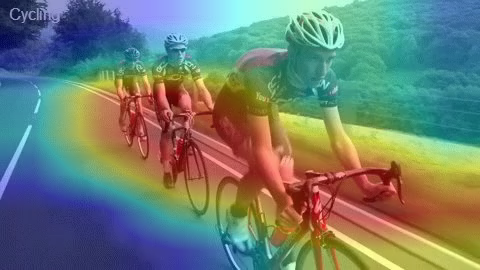


🔥 Heatmap:


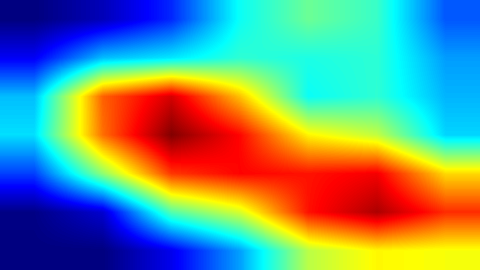


🟦 Frame 2
📊 Mean Activation: 0.473
📈 Max Activation: 1.000
🎯 Focus Ratio: 24.49%

🔹 Grad-CAM Overlay:


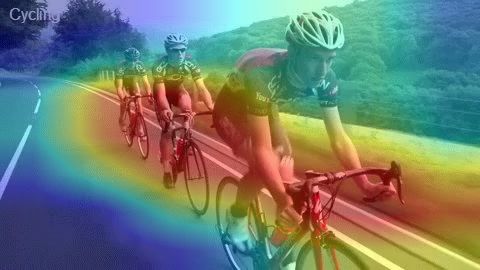


🔥 Heatmap:


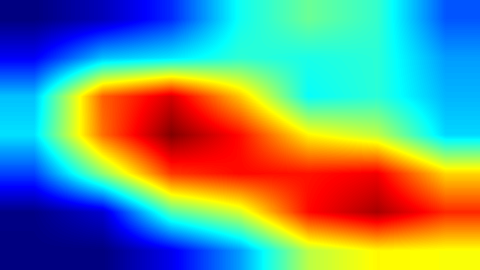


🟦 Frame 3
📊 Mean Activation: 0.435
📈 Max Activation: 1.000
🎯 Focus Ratio: 18.37%

🔹 Grad-CAM Overlay:


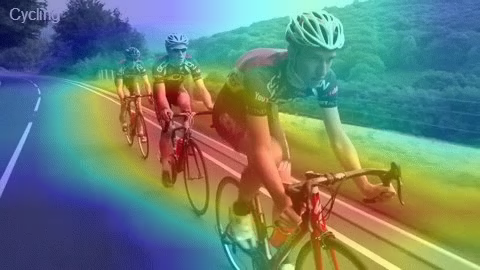


🔥 Heatmap:


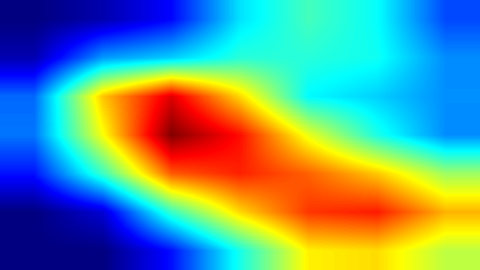


🟦 Frame 4
📊 Mean Activation: 0.449
📈 Max Activation: 1.000
🎯 Focus Ratio: 20.41%

🔹 Grad-CAM Overlay:


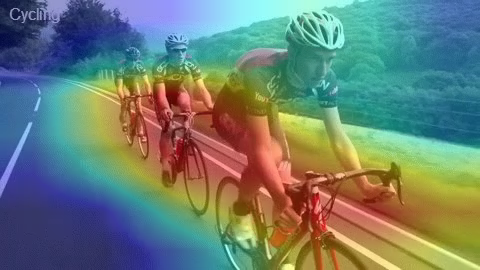


🔥 Heatmap:


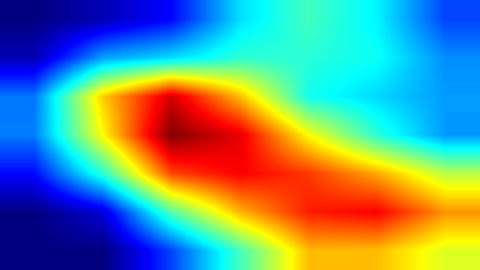


🟦 Frame 5
📊 Mean Activation: 0.433
📈 Max Activation: 1.000
🎯 Focus Ratio: 20.41%

🔹 Grad-CAM Overlay:


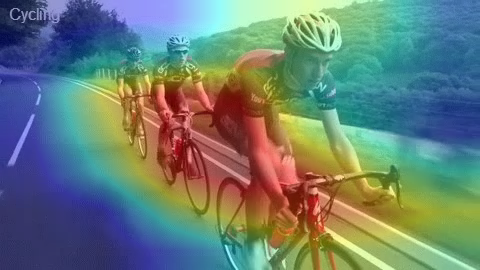


🔥 Heatmap:


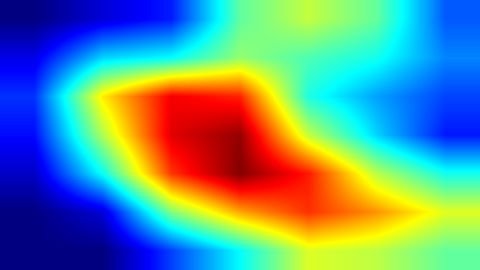


🛑 Stopped after 5 frames for demo.

✅ Visualization complete.


In [7]:
video_path = "/content/cycling.mp4"  # 🔹 Change this path
vgc = VideoGradCAM(video_path)
vgc.start()


🔥 Combined (Average) Grad-CAM Heatmap for Entire Video 🔥


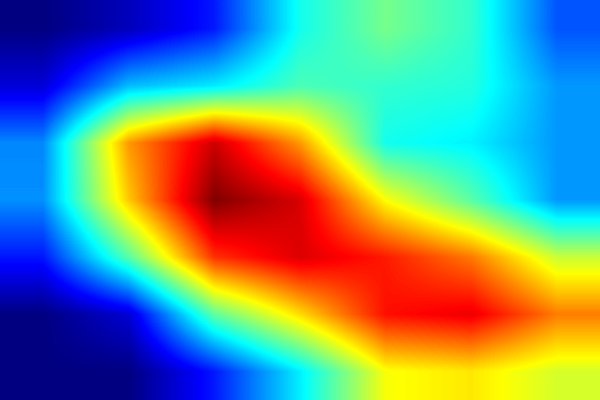

✅ Combined average heatmap displayed successfully.


In [8]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

if hasattr(vgc, "all_maps") and len(vgc.all_maps) > 0:
    print("\n🔥 Combined (Average) Grad-CAM Heatmap for Entire Video 🔥")

    # 1️⃣ Compute average Grad-CAM
    avg_heatmap = np.mean(np.array(vgc.all_maps), axis=0)

    # 2️⃣ Normalize to 0–1 range
    avg_heatmap = (avg_heatmap - np.min(avg_heatmap)) / (np.max(avg_heatmap) - np.min(avg_heatmap) + 1e-8)

    # 3️⃣ Convert to uint8 and resize
    avg_heatmap_uint8 = np.uint8(255 * avg_heatmap)
    avg_heatmap_resized = cv2.resize(avg_heatmap_uint8, (600, 400), interpolation=cv2.INTER_LINEAR)

    # 4️⃣ Apply color map
    avg_heatmap_color = cv2.applyColorMap(avg_heatmap_resized, cv2.COLORMAP_JET)

    # 5️⃣ Display combined heatmap
    cv2_imshow(avg_heatmap_color)
    print("✅ Combined average heatmap displayed successfully.")
else:
    print("⚠️ No Grad-CAM maps found. Run `vgc.start()` first.")